In [1]:
import os
import cv2
import numpy as np
import random
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

def plot_metric(metric_name_1, metric_name_2, plot_name):

  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time
  epochs = range(len(metric_value_1))

  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()
  plt.show()
  plt.close()

def create_model(image_height, image_width, model_output_size):
    model = Sequential()

    # input shape = 64 x 64 x (3 + 3) --> 3 rgb channels for color and 3 rgb channels for depth
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 6)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()
    return model

def create_dataset(path_dataset):
    temp_features = []
    features = []
    labels = []

    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        for file in os.listdir(path_dataset + '/' + class_name):
            if file.endswith('_color.jpg'):
                filename = file.replace('_color.jpg', '')
                img_color = cv2.imread(path_dataset+'/'+class_name+'/'+filename+'_color.jpg')
                img_depth = cv2.imread(path_dataset+'/'+class_name+'/'+filename+'_depth.jpg')

                try:
                    resized_color = cv2.resize(img_color, (image_height, image_width))
                    resized_depth = cv2.resize(img_depth, (image_height, image_width))
                except:
                    continue

                normalized_color = resized_color/255
                normalized_depth = resized_depth/255

                temp_features.append(cv2.merge([normalized_color, normalized_depth]))
        features.extend(temp_features)
        labels.extend([class_index] * len(temp_features))
        temp_features.clear()

    features = np.asarray(features).astype(np.float32)
    labels = np.array(labels)

    return features, labels

def get_output_layers(net):

    layer_names = net.getLayerNames()

    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers

def draw_prediction(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    #cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

def object_detection_frame(args_image, args_config, args_weights):

    image = args_image.copy()

    Width = image.shape[1]
    Height = image.shape[0]
    scale = 0.00392

    net = cv2.dnn.readNet(args_weights, args_config)

    blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

    net.setInput(blob)

    outs = net.forward(get_output_layers(net))

    class_ids = []
    confidences = []
    boxes = []
    conf_threshold = 0.5
    nms_threshold = 0.4


    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])


    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    persons = []

    for i in indices:
        i = i[0]
        box = boxes[i]
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]

        if str(classes[class_ids[i]]) == 'person':
            persons.append([round(x), round(y), round(x+w), round(y+h), COLORS[class_ids[i]]])
            draw_prediction(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

    #cv2.imshow("object detection", image)
    #cv2.waitKey()

    #cv2.imwrite("object-detection.jpg", image)
    #cv2.destroyAllWindows()
    return image, persons

def human_activity_detection(img_color, img_depth, model, classes_list):
    activities = []
    label = ''
    
    try:
        resized_color = cv2.resize(img_color, (image_height, image_width))
        resized_depth = cv2.resize(img_depth, (image_height, image_width))
    except:
        print(img_color.shape)
        print(img_depth.shape)
        return label

    normalized_color = resized_color/255
    normalized_depth = resized_depth/255

    features = cv2.merge([normalized_color, normalized_depth])

    predicted_labels_probabilities = model.predict(np.expand_dims(features, axis = 0))[0]
    avg = np.average(predicted_labels_probabilities)
        
        # running, sitting, standing, walking
        # walking_down_stairs, walking_up_stairs
        # with_mask, without_mask, wrong_use_mask
    
    dict = {}
    for lbl_idx, lbl_vle in enumerate(predicted_labels_probabilities):
        dict[classes_list[lbl_idx]] = lbl_vle

    dict_movement = {
        'running': dict['running'],
        'sitting': dict['sitting'],
        'standing': dict['standing'],
        'walking': dict['walking'],
        'walking_down_stairs': dict['walking_down_stairs'],
        'walking_up_stairs': dict['walking_up_stairs'],
        'trotinete': dict['trotinete']
    }
    
    dict_mask = {
        'with_mask': dict['with_mask'],
        'without_mask': dict['without_mask'],
        'wrong_use_mask': dict['wrong_use_mask']
    }
    
    dict_action = {
        'on_the_phone': dict['on_the_phone'],
        'writing': dict['writing']
    }
    
    max_movement_key = max(dict_movement, key=dict_movement.get)
    max_mask_key = max(dict_mask, key=dict_mask.get)

    value_movement = dict_movement[max_movement_key]
    value_mask = dict_mask[max_mask_key]
        
        
    if (value_movement >= avg):
        activities.append(max_movement_key)
    if (value_mask >= avg):
        activities.append(max_mask_key)
    for action_key in dict_action:
        if (dict[action_key] >= avg):
            activities.append(action_key)


    for activity in activities:
        if label == '':
            label = str(activity)
        else:
            label = str(label) + '/' + str(activity)
    return label

In [3]:
path_dataset = './dataset'

image_height, image_width = 64, 64
classes_list = []

for entry in os.scandir(path_dataset):
    if entry.is_dir():
        classes_list.append(entry.name)
model_output_size = len(classes_list)

features, labels = create_dataset(path_dataset)
one_hot_encoded_labels = to_categorical(labels)

features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)


# id = 0
# label = classes_list[labels[id]]
# feature = features[id]
# print(feature.shape)

Extracting Data of Class: on_the_phone
Extracting Data of Class: running
Extracting Data of Class: sitting
Extracting Data of Class: standing
Extracting Data of Class: trotinete
Extracting Data of Class: walking
Extracting Data of Class: walking_down_stairs
Extracting Data of Class: walking_up_stairs
Extracting Data of Class: without_mask
Extracting Data of Class: with_mask
Extracting Data of Class: writing
Extracting Data of Class: wrong_use_mask


In [4]:
model = create_model(image_height, image_width, model_output_size)
#plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = 2 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])
#model_training_history = model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = 2 , shuffle = True, validation_split = 0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        3520      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 64)       256       
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1

In [5]:
model_evaluation_history = model.evaluate(features_test, labels_test)

# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'


# Saving your Model
model.save(model_name)

24/24 [==============================] - 0s 9ms/step - loss: 2.1273 - accuracy: 0.2594


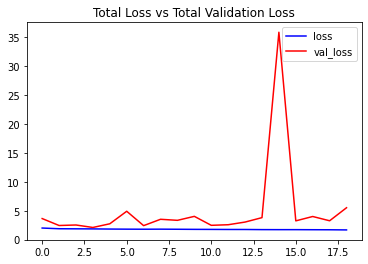

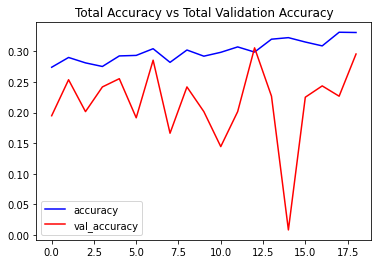

In [6]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [11]:
args_config = "./yolov3.cfg"
args_weights = "./yolov3.weights"
args_classes = "./yolov3.txt"

video_path = './videos/'
video = '001'
video_color = 'video_color_escada_'
video_depth = 'video_depth_escada_'
video_out = './output/'+video+'.mov'

#out_path = './Samples/'

classes = None
with open(args_classes, 'r') as f:
    classes = [line.strip() for line in f.readlines()]
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))


v_color = str(video_path) + str(video_color) + str(video) + str('.mov')
v_depth = str(video_path) + str(video_depth) + str(video) + str('.mov')

cap = cv2.VideoCapture(str(v_color))
cap_depth = cv2.VideoCapture(str(v_depth))

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter(video_out, cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

if (cap.isOpened() == False):
    print("Error opening color video file")

if (cap_depth.isOpened() == False):
    print("Error opening depth video file")
while (cap.isOpened() & cap_depth.isOpened()):
    ret, frame = cap.read()
    ret_d, frame_d = cap_depth.read()
    if (ret == True & ret_d == True):

        frame_yolo, persons = object_detection_frame(frame, args_config, args_weights)

        for p in persons:
        # x1, y1, x2 '001
            x1 = p[0]
            y1 = p[1]
            x2 = p[2]
            y2 = p[3]
            color = p[4]
            img_person = frame[y1:y2, x1:x2]
            img_depth = frame_d[y1:y2, x1:x2]

            activities = human_activity_detection(img_person, img_depth, model, classes_list)

            cv2.putText(frame_yolo, activities, (x1-10,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        out.write(frame_yolo)
        cv2.imshow('Output', frame_yolo)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    else:
        break

cap.release()
cap_depth.release()
out.release()
cv2.destroyAllWindows()

(132, 0, 3)
(132, 0, 3)
